
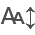

In [5]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)

In [7]:
conn_str = os.getenv("CRAIGGER_CONN")  # make sure the tunnel is open
engine = create_engine(conn_str)

In [8]:
df = pd.read_sql(
    """
    SELECT 
  "gaddress", 
  replace(
    replace(price, '$', ''), 
    ',', 
    ''
  ):: numeric AS current_rent, 
  "glat"::numeric,
  "glng"::numeric,
  "bedbath", 
  "NumOfBeds", 
  "screenshot",
  "NumOfBaths", 
  coalesce(
    nullif("SqftMain", ''), 
    '0.00'
  ):: numeric(10, 2) AS sqft, 
  "BaseValue_Year", 
  "AIN",
  "CurrentRoll_BaseYear", 
  "CurrentRoll_LandValue" :: numeric + "CurrentRoll_ImpValue" :: numeric AS current_assessment 
FROM 
  "padmapper_ads" 
WHERE 
  "UseType" = 'Single Family Residence' 
  AND "SqftMain" IS NOT NULL 
  AND "NumOfBeds" != ''
  AND "NumOfBaths" != '';
""",
    con=engine,
)
df["rent_per_sqft"] = df["current_rent"] / df["sqft"]
df["assessment_per_sqft"] = df["current_assessment"] / df["sqft"]
df = df[df["assessment_per_sqft"] > 1]
df["assessment_to_rent_ratio"] = df["current_assessment"] / df["current_rent"]
df["years_held"] = df["CurrentRoll_BaseYear"].map(int) - df["BaseValue_Year"].map(int)
df = df.drop_duplicates().dropna()
df["screenshot"] = "https://rycpt-crawls.s3.us-west-2.amazonaws.com/" + df["screenshot"]
df["lagov"] = "https://portal.assessor.lacounty.gov/parceldetail/" + df["AIN"]
print(df.shape)
df

(9117, 18)


gaddress  current_rent  \
0               458 Geneva Ave, Claremont, CA 91711, USA        2950.0   
1      526 Floral Park Terrace, S Pasadena, CA 91030,...        5500.0   
2       10045 W Chardonnay Ct, Sun Valley, CA 91352, USA        4800.0   
3          6627 Birchton Ave, Canoga Park, CA 91307, USA        6350.0   
4            17328 Keswick St, Northridge, CA 91325, USA        4800.0   
...                                                  ...           ...   
12362      11570 Braddock Dr, Culver City, CA 90230, USA        5750.0   
12368          1126 Yale St, Santa Monica, CA 90403, USA       23400.0   
12423         1424 W 37th Dr, Los Angeles, CA 90018, USA        1195.0   
12424    750 N Martel Ave, West Hollywood, CA 90046, USA        6500.0   
12426    6114 Temple Hill Dr, Los Angeles, CA 90068, USA       12300.0   

            glat        glng                   bedbath NumOfBeds  \
0      34.087629 -117.725562  3 Bedrooms · 2 Bathrooms         3   
1      34.119996 -118.161881   3 Bedrooms · 1 Bathroom         2   
2      34.216754 -118.350262  4 Bedrooms · 3 Bathrooms         3   
3      34.190662 -118.641677  4 Bedrooms · 2 Bathrooms         4   
4      34.209421 -118.511011  4 Bedrooms · 3 Bathrooms         3   
...          ...         ...                       ...       ...   
12362  33.996885 -118.411153   2 Bedrooms · 1 Bathroom         2   
12368  34.038962 -118.475864  5 Bedrooms · 7 Bathrooms         5   
12423  34.018780 -118.301033    1 Bedroom · 1 Bathroom         3   
12424  34.085196 -118.350891  2 Bedrooms · 2 Bathrooms         2   
12426  34.110619 -118.322870  2 Bedrooms · 2 Bathrooms         2   

                                              screenshot NumOfBaths    sqft  \
0      https://rycpt-crawls.s3.us-west-2.amazonaws.co...          2  1489.0   
1      https://rycpt-crawls.s3.us-west-2.amazonaws.co...          2  1575.0   
2      https://rycpt-crawls.s3.us-west-2.amazonaws.co...          3  2392.0   
3      https://rycpt-crawls.s3.us-west-2.amazonaws.co...          2  1570.0   
4      https://rycpt-crawls.s3.us-west-2.amazonaws.co...          2  1621.0   
...                                                  ...        ...     ...   
12362  https://rycpt-crawls.s3.us-west-2.amazonaws.co...          1   795.0   
12368  https://rycpt-crawls.s3.us-west-2.amazonaws.co...          7  4722.0   
12423  https://rycpt-crawls.s3.us-west-2.amazonaws.co...          2  1732.0   
12424  https://rycpt-crawls.s3.us-west-2.amazonaws.co...          1  1112.0   
12426  https://rycpt-crawls.s3.us-west-2.amazonaws.co...          1   803.0   

      BaseValue_Year         AIN CurrentRoll_BaseYear  current_assessment  \
0               2002  8316005016                 2022            269809.0   
1               2007  5317037006                 2022           1069336.0   
2               2002  2403029006                 2022            531483.0   
3               2010  2036026028                 2022            583847.0   
4               1981  2202009015                 2022            229484.0   
...              ...         ...                  ...                 ...   
12362           2012  4217026002                 2024            369418.0   
12368           2011  4266009046                 2024           3467496.0   
12423           2013  5041030028                 2024            307112.0   
12424           2018  5526009016                 2024           1338618.0   
12426           2018  5585022012                 2024           1148979.0   

       rent_per_sqft  assessment_per_sqft  assessment_to_rent_ratio  \
0           1.981195           181.201478                 91.460678   
1           3.492063           678.943492                194.424727   
2           2.006689           222.191890                110.725625   
3           4.044586           371.877070                 91.944409   
4           2.961135           141.569402                 47.809167   
...              ...                  ... 

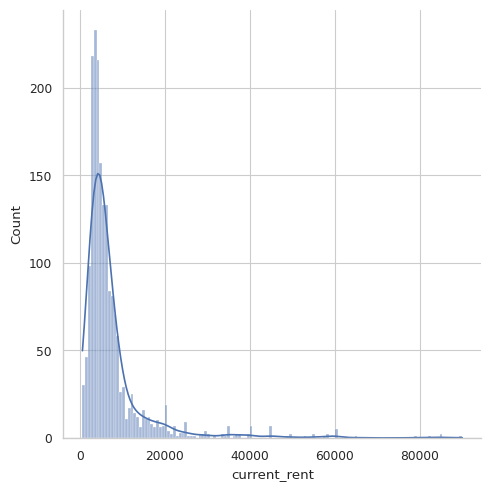

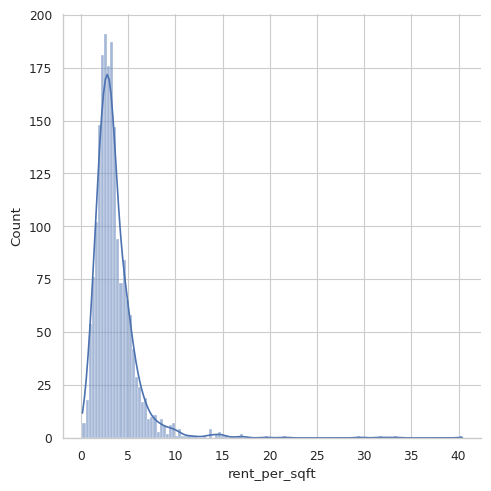

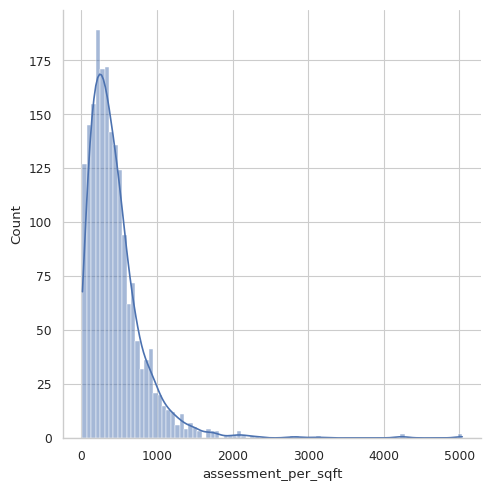

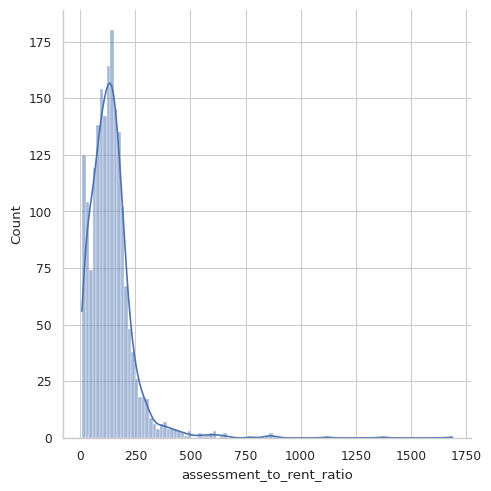

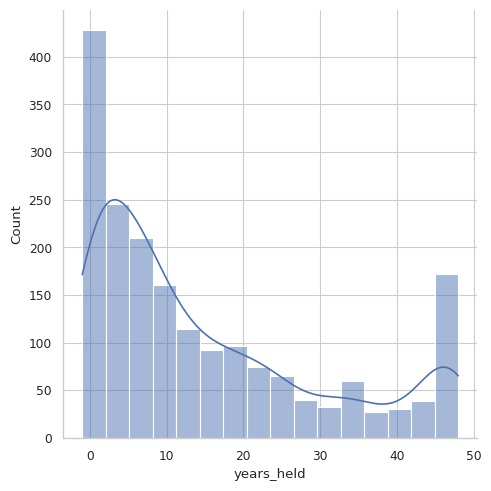

In [29]:
# loop through each column and plot a displot
for column in [
    "current_rent",
    "rent_per_sqft",
    "assessment_per_sqft",
    "assessment_to_rent_ratio",
    "years_held",
]:
    sns.displot(df[column], kde=True)

Text(0.5, 1.04, 'Tax Assessment per sqft vs. Rent per sqft\nPadmapper rental ads in Los Angeles')

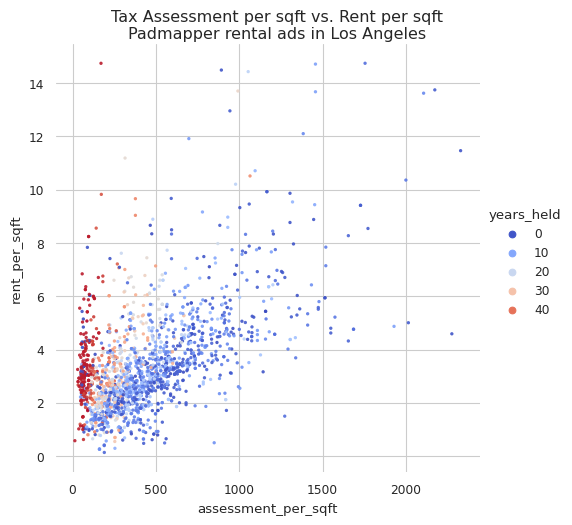

In [36]:
sns.set_theme(style="whitegrid")
sns.set_context("paper")

cmap = sns.color_palette("coolwarm", as_cmap=True)

df = df[df.assessment_per_sqft < 2500]
df = df[df.rent_per_sqft < 15]
df['years_held > 30'] = df.years_held > 30

g = sns.relplot(
    data=df,
    x="assessment_per_sqft",
    y="rent_per_sqft",
    hue="years_held",
    linewidth=0,
    alpha=0.9,
    palette=cmap,
    marker=".",
)
g.despine(left=True, bottom=True)
plt.suptitle(
    "Tax Assessment per sqft vs. Rent per sqft\nPadmapper rental ads in Los Angeles",
    y=1.04,
)
# plt.savefig(
#    os.path.join(
#        os.environ["HOME"], "ryancompton.net/assets/pix/tax_vs_rent_padmapper.png"
#    )
# )

Text(0.5, 1.04, 'Tax Assessment per sqft vs. Rent per sqft\nPadmapper rental ads in Los Angeles')

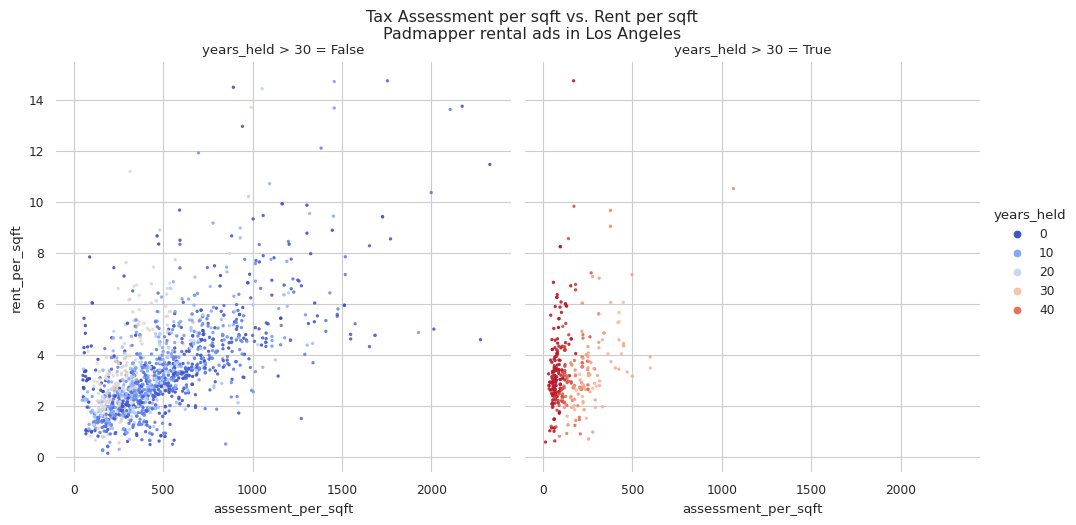

In [37]:
sns.set_theme(style="whitegrid")
sns.set_context("paper")

cmap = sns.color_palette("coolwarm", as_cmap=True)

df = df[df.assessment_per_sqft < 2500]
df = df[df.rent_per_sqft < 15]

g = sns.relplot(
    data=df,
    x="assessment_per_sqft",
    y="rent_per_sqft",
    hue="years_held",
    linewidth=0,
    alpha=0.9,
    palette=cmap,
    marker=".",
    col="years_held > 30"
)
g.despine(left=True, bottom=True)
plt.suptitle(
    "Tax Assessment per sqft vs. Rent per sqft\nPadmapper rental ads in Los Angeles",
    y=1.04,
)
plt.savefig(
   os.path.join(
       os.environ["HOME"], "ryancompton.net/assets/pix/tax_vs_rent_padmapper_yh30.png"
   )
)

In [31]:
hex_cmap = sns.color_palette("coolwarm", n_colors=len(set(df.years_held))).as_hex()


def get_color(x):
    for idx, years in enumerate(sorted(set(df.years_held))):
        if x == years:
            return hex_cmap[max(0, idx)]


df["gmap_color"] = df["years_held"].map(get_color)

df["assessment_to_rent_ratio"] = df["assessment_to_rent_ratio"].round(2)
dfp = df[
    [
        "glat",
        "glng",
        "gmap_color",
        "gaddress",
        "current_rent",
        "current_assessment",
        "assessment_to_rent_ratio",
        "BaseValue_Year",
        "lagov",
        "screenshot",
    ]
]
print(dfp.sample(10).to_csv(sep="\t", index=False))

glat	glng	gmap_color	gaddress	current_rent	current_assessment	assessment_to_rent_ratio	BaseValue_Year	lagov	screenshot
34.2120032	-118.624793	#dfdbd9	7801 McLaren Ave, Canoga Park, CA 91304, USA	5350.0	251255.0	46.96	1998	https://portal.assessor.lacounty.gov/parceldetail/2014010011	https://rycpt-crawls.s3.us-west-2.amazonaws.com/padmapper-data/2023-07-05/7801_McLaren_Ave,_Canoga_Park,_CA_91304,_USA.png
34.1536746	-118.7886782	#7396f5	5650 Lake Lindero Dr, Agoura Hills, CA 91301, USA	6500.0	770116.0	118.48	2015	https://portal.assessor.lacounty.gov/parceldetail/2054014001	https://rycpt-crawls.s3.us-west-2.amazonaws.com/padmapper-data/2023-05-29/5650_Lake_Lindero_Dr,_Agoura_Hills,_CA_91301,_USA.png
34.0322875	-118.7252281	#5f7fe8	25252 Malibu Rd, Malibu, CA 90265, USA	55000.0	10614798.0	193.0	2018	https://portal.assessor.lacounty.gov/parceldetail/4459016007	https://rycpt-crawls.s3.us-west-2.amazonaws.com/padmapper-data/2023-05-27/25252_Malibu_Rd,_Malibu,_CA_90265,_USA.png
34.0206679	-118.

In [32]:
dfp.to_csv(
    "/home/ryn/ryancompton.net/assets/taxrentlocations.tsv", sep="\t", index=False
)